## Forecasts from the ECDC FCH

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pyprojroot import here

In [45]:
from datetime import date

min_date = date(2020, 10, 12)
max_date = date(2021, 9, 15)

In [46]:
import pandas as pd


def forecast_long_to_wide(df: pd.DataFrame) -> pd.DataFrame:
    # Quantile column mapping
    forecast_quantiles = [
        0.01,
        0.025,
        *[round(0.05 * q, 3) for q in range(1, 20)],
        0.975,
        0.99,
    ]
    col_map = {q: f"{q * 100:.1f} %" for q in forecast_quantiles}

    # Pivot quantile rows
    q = df[df["type"] == "quantile"].copy()
    q["quantile"] = pd.to_numeric(q["quantile"])
    piv = (
        q[q["quantile"].isin(col_map)]
        .pivot(index="target_end_date", columns="quantile", values="value")
        .rename(columns=col_map)
    )

    # Add mean and sd (if present)
    res = piv.copy()
    means = (
        df[df["type"] == "mean"][["target_end_date", "value"]]
        .drop_duplicates()
        .set_index("target_end_date")
        .rename(columns={"value": "mean"})
    )
    res = res.join(means)

    # Set final column order and output
    cols = ["mean", *col_map.values()]
    out = res[cols].reset_index().rename(columns={"target_end_date": "date"})
    return out

In [47]:
import os
from pathlib import Path
import subprocess
import pandas as pd


def standardize_forecast_dfs(daily_predictions: pd.DataFrame):

    query_string = (
        "target == '1 wk ahead inc case' and (location == 'DE' or location == 'GM')"
    )

    wide_df = forecast_long_to_wide(
        daily_predictions.query(query_string)[
            ["target_end_date", "type", "quantile", "value"]
        ]
    )

    wide_df["date"] = pd.to_datetime(wide_df["date"], format="%Y-%m-%d").dt.date

    return wide_df[(wide_df["date"] >= min_date) & (wide_df["date"] <= max_date)]


def read_fch_submissions(
    model_dir: str, repo_url: str, clone_dir: Path
) -> pd.DataFrame:
    if not clone_dir.exists():
        subprocess.run(
            ["git", "clone", "--depth", "1", repo_url, str(clone_dir)], check=True
        )

    csv_dir_path = clone_dir / model_dir
    csv_files = [
        csv_dir_path / file
        for file in os.listdir(csv_dir_path)
        if file.endswith(".csv")
    ]

    combined_df = pd.concat(
        [
            pd.read_csv(file_path).assign(filename=file_path.name)
            for file_path in csv_files
        ],
        ignore_index=True,
    )

    return standardize_forecast_dfs(combined_df)

In [48]:
# Define repository and local clone directory
model_names = ["ITWW-county_repro", "EuroCOVIDhub-baseline", "EuroCOVIDhub-ensemble"]

models_ecdc = {
    name: read_fch_submissions(
        f"data-processed/{name}",
        "https://github.com/european-modelling-hubs/covid19-forecast-hub-europe_archive.git",
        Path("/tmp/covid19-forecast-hub-europe_archive"),
    )
    for name in model_names
}

itww_county_repro = models_ecdc["ITWW-county_repro"]
baseline = models_ecdc["EuroCOVIDhub-baseline"]
ensemble = models_ecdc["EuroCOVIDhub-ensemble"]

In [49]:
for model, df in models_ecdc.items():
    df.to_csv(here(f"data/processed/ECDC_FCH_{model}.csv"), index=False)

## Forecasts from the German FCH

In [53]:
from datetime import timedelta


fch_repo_url = "https://github.com/KITmetricslab/covid19-forecast-hub-de"


def fch_data_url(model: str, forecast_date: date) -> str:
    submission_date = (forecast_date + timedelta(days=-5)).strftime("%Y-%m-%d")
    return f"https://raw.githubusercontent.com/KITmetricslab/covid19-forecast-hub-de/refs/heads/master/data-processed/{model}/{submission_date}-Germany-{model}-case.csv"


forecast_dates = pd.date_range(
    start=date(2020, 10, 12), end=date(2021, 9, 15), freq="W-SAT"
).date.tolist()

fch_models = ["KIT-baseline", "ITWW-county_repro", "KITCOVIDhub-median_ensemble"]
fch_dfs = {
    model: pd.concat(
        [
            pd.read_csv(fch_data_url(model, fd))
            for fd in tqdm(forecast_dates, desc=f"Reading {model}")
        ]
    )
    for model in fch_models
}

Reading KIT-baseline:   0%|          | 0/48 [00:00<?, ?it/s]

Reading ITWW-county_repro:   0%|          | 0/48 [00:00<?, ?it/s]

Reading KITCOVIDhub-median_ensemble:   0%|          | 0/48 [00:00<?, ?it/s]

In [54]:
standardize_forecast_dfs(fch_dfs["KITCOVIDhub-median_ensemble"])

,date,mean,1.0 %,2.5 %,5.0 %,10.0 %,15.0 %,20.0 %,25.0 %,30.0 %,...,60.0 %,65.0 %,70.0 %,75.0 %,80.0 %,85.0 %,90.0 %,95.0 %,97.5 %,99.0 %
0,2020-10-17,NaN,21539.423788,22569.355225,23568.090312,24586.979322,25139.325838,25561.499631,25932.539485,26277.073961,...,28591.117862,29302.140058,30152.710629,31079.838904,32123.809361,33356.524172,34932.633915,37322.459967,39450.101466,41991.884426
1,2020-10-24,NaN,36259.974108,40010.212500,43312.925000,47192.300000,49605.825000,51872.358536,52952.611707,53923.109962,...,58291.199381,58716.924259,59153.412378,59671.920685,60831.195953,62635.234335,64701.151489,67693.593562,70602.392253,74215.002332
2,2020-10-31,NaN,71773.589517,73638.165669,75280.502599,77219.523177,79654.000000,83829.000000,87584.000000,90963.000000,...,107475.000000,110180.000000,112972.000000,116318.000000,119771.000000,123925.000000,126976.861592,130891.717572,133932.255716,138512.637213
3,2020-11-07,NaN,128928.056101,131639.839424,134138.933859,138871.261618,141210.839387,143696.640767,145158.876872,146898.054911,...,153972.172672,155487.580999,156963.110160,159133.790947,163005.450209,167518.341931,173196.590203,181612.609510,188912.251145,197399.662078
4,2020-11-14,NaN,119952.026330,129980.150000,136067.000000,137503.000000,138904.000000,140194.000000,141949.000000,147334.000000,...,173572.000000,177833.000000,182631.000000,187491.000000,193217.000000,199890.000000,207928.000000,219977.000000,231903.000000,246066.000000
5,2020-11-21,NaN,97396.242482,104060.481932,110108.458379,115683.488800,119223.418142,120945.000000,122059.000000,123346.000000,...,136235.901986,139750.219440,146430.900000,153778.250000,163680.600000,170636.000000,177966.000000,187194.000000,197020.000000,208404.000000
6,2020-11-28,NaN,75040.120473,82538.858916,89002.873287,97030.960444,102229.248647,106634.864174,110372.743812,113812.616748,...,129905.667002,132834.295917,137257.829453,143179.904368,147545.934159,152884.334404,159796.770812,170003.316064,179230.239236,190778.863126
7,2020-12-05,NaN,99073.714364,103654.377174,106429.500825,110397.726206,113170.402772,115296.137416,117413.526398,118612.429230,...,123892.058085,124821.077343,125814.051913,129138.353260,130552.346895,132309.689481,134185.351891,136810.836639,138873.171844,144911.747438
8,2020-12-12,NaN,102028.092074,106971.000000,110320.900000,115605.200000,118121.700000,120789.500000,123099.200000,125180.900000,...,136966.944209,137670.389527,141174.700000,145046.100000,147937.200000,151471.400000,154830.700000,162936.000000,168541.900000,174167.200000
9,2020-12-19,NaN,118050.856771,123185.524846,127674.122385,132990.545650,136580.749582,139517.928723,141841.483594,143634.146435,...,163604.357360,166131.343093,170999.825897,179230.857426,181605.922234,186100.779239,189526.778717,197975.255846,201728.712142,205654.302086


In [58]:
for model, df in fch_dfs.items():
    standardize_forecast_dfs(df).to_csv(
        here(f"data/processed/KIT_FCH_{model}.csv"), index=False
    )

## RKI truth

In [37]:
truth = (
    pd.read_csv(here("data/processed/RKI_county_weekly.csv"))
    .groupby("date")
    .agg(cases=("cases", "sum"))
)
truth["date"] = pd.to_datetime(truth.index, format="%Y-%m-%d").date
truth.reset_index(drop=True, inplace=True)

In [38]:
truth = truth[(truth["date"] >= min_date) & (truth["date"] <= max_date)]

In [ ]:
assert all(truth.date.values == itww_county_repro.date.values)
assert all(truth.date.values == baseline.date.values)
assert all(truth.date.values == ensemble.date.values)

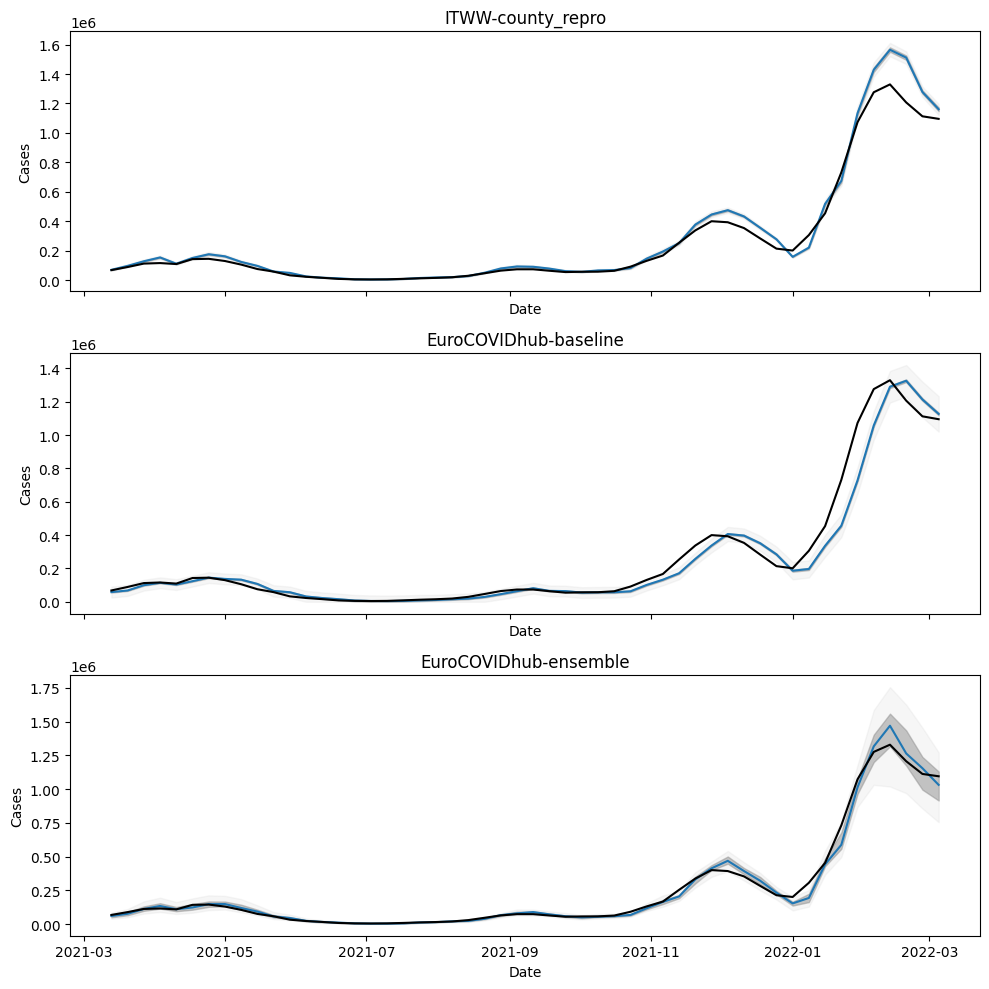

In [ ]:
fig, axs = plt.subplots(3, figsize=(10, 10), sharex=True)

for ax, model_name in zip(axs, model_names):
    df = models[model_name]
    ax.plot(df.date, df["50.0 %"])
    ax.fill_between(df.date, df["25.0 %"], df["75.0 %"], color="gray", alpha=0.5)
    ax.fill_between(df.date, df["2.5 %"], df["97.5 %"], color="lightgray", alpha=0.2)
    ax.set_title(model_name)

    ax.plot(truth["date"], truth["cases"], color="black")
    ax.set_ylabel("Cases")
    ax.set_xlabel("Date")

plt.tight_layout()
plt.show()

In [57]:
pd.concat(
    (
        standardize_forecast_dfs(fch_dfs["KITCOVIDhub-median_ensemble"]),
        standardize_forecast_dfs(models_ecdc["EuroCOVIDhub-ensemble"]),
    ),
    ignore_index=True,
)

UndefinedVariableError: name 'target' is not defined